# Análise de dados e construção de modelo de machine learning para análise de fake news


- importando libs para análise de dados

In [2]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import re
import collections
import nltk
import time

## Importando o arquivo com todas as notícias

In [2]:
todas_noticias = pd.read_csv('datasets/todos_os_dados.csv')
todas_noticias.target.unique()

array(['falso', 'verdadeiro'], dtype=object)

## Limpeza dos dados (Feature engineering)

- Para esta análise de dados não precisaremos do link da imagem nem da origem da notícia
- Vamos trabalhar apenas com a coluna `info` e a coluna `target`

In [3]:
todas_noticias = todas_noticias[['info', 'target']]
todas_noticias.sample(5)

,info,target
7634,\nSabe aquela índia mentirosa que o Bolsonaro ...,falso
10920,“Aí vem Sergio Moro e simplesmente tira as tom...,falso
6847,"O Supremo Tribunal Federal (STF) decidiu, nes...",verdadeiro
7893,\nVocê sabia que 2% de toda arrecadação do veí...,falso
3591,"Marcelo Resende fala sobre o câncer: ""As droga...",falso


**Renomeando:** Serão renomeadas o nome das colunas para português, estamos trabalhando com dados em português e o código também segue o padrão português, também para facilitar o entendimento de quem irá consumir este notebook

In [4]:
colunas = {'info': 'texto', 'target': 'classificacao'}
todas_noticias.rename(columns=colunas, inplace=True)

### Total de notícias verdadeiras:

In [5]:
len(todas_noticias[todas_noticias.classificacao == 'verdadeiro'])

5014

### Total de notícias falsas

In [6]:
len(todas_noticias[todas_noticias.classificacao == 'falso'])

7497

### Total de notícias

In [7]:
len(todas_noticias)

12511

- Verificar se existem dados vazios ou inválidos nas colunas info e target

A função assert joga um erro se encontrar algum dado 

In [8]:
num_texto_null = len(todas_noticias[todas_noticias['texto'].isnull()])
num_texto_vazio = len(todas_noticias[todas_noticias['texto'].isna()])
assert  num_texto_null + num_texto_vazio == 0

In [9]:
num_classificacao_null = len(todas_noticias[todas_noticias['classificacao'].isnull()]) 
num_classificacao_vazio = len(todas_noticias[todas_noticias['classificacao'].isna()])
assert num_classificacao_vazio + num_classificacao_null == 0

### Normalizando os dados

- Passar todos os dados para lowercase para que não haja distinção entre maíusculo e minúsculo
- Remover acentuação, aspas e possíveis caracteres especiais

In [10]:
todas_noticias.texto = todas_noticias.texto.map(lambda x: x.lower())

### Removendo acentuação 

- usando a lib `unidecode` remove a acentuação das palavras

In [11]:
todas_noticias.texto = todas_noticias.texto.map(lambda x: unidecode(x))

### Removendo caracteres especiais

- Expressões regulares podem ser usadas para remover caracteres especiais


In [12]:
todas_noticias.texto = todas_noticias.texto.map(lambda x: re.sub('[\W_0-9]+', ' ', x))

## Contando as palavaras

- Montando um contador geral 
- Montando um contador de palavras comuns para fake news
- Montando um contador de palavras comuns para notícias verdadeiras


In [13]:
verdadeiro_count = collections.Counter()
falso_count = collections.Counter()
todas_count = collections.Counter()

In [14]:
def contagem(contador_por_classe, noticia):
    for palavra in noticia:
        print(palavra)
        contador_por_classe.update(palavra)
        todas_count.update(palavra)
    return contador_por_classe
    

In [15]:
for index, row in todas_noticias.iterrows():
    noticia = row['texto'].split(' ')
    if row['classificacao'] == 'verdadeiro':
        verdadeiro_count.update(noticia)
    else:
        falso_count.update(noticia)
    todas_count.update(noticia)

In [16]:
razao_falso_verdadeira = collections.Counter()

In [17]:
for word, count in list(todas_count.most_common()):
    if count > 10:
        razao = verdadeiro_count[word] / float(falso_count[word] + 1)
        razao_falso_verdadeira[word] = razao

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/willian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
verdadeiro_count_plot = verdadeiro_count.copy()
falso_count_plot = falso_count.copy()

In [20]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [21]:
palavras_comuns = [unidecode(palavra) for palavra in stopwords]

In [22]:
for palavra in palavras_comuns:
    if palavra in list(falso_count):
        del falso_count[palavra]
    if palavra in list(verdadeiro_count):
        del verdadeiro_count[palavra]   

In [23]:
vocabulario = set(todas_count.keys())   

In [24]:
len(vocabulario)

82080

In [25]:
len(todas_noticias)

12511

## Visualização de dados

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import seaborn as sns

In [28]:
df_most_commom = pd.DataFrame(todas_count.most_common(), columns=['word', 'count'])

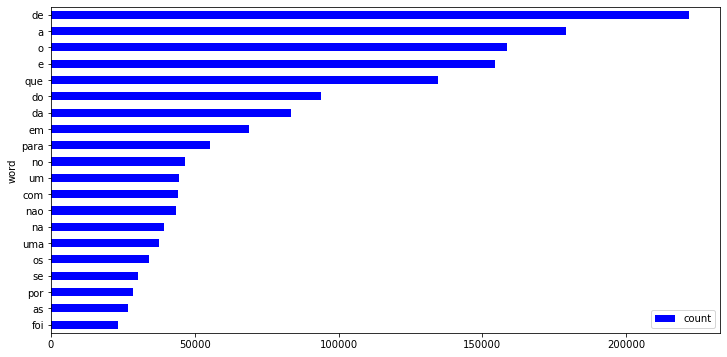

In [29]:
## top mais comuns
df_most_commom[:20].plot.barh(x='word', y='count', color='blue').invert_yaxis()
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

In [30]:
df_all = pd.DataFrame.from_dict(todas_count, orient='index').reset_index()
df_all.head()
df_all.rename(columns={'index':'word', 0:'count'}, inplace=True)

In [31]:
df_verdadeiro_count = pd.DataFrame(verdadeiro_count_plot.most_common(),columns=['word','count'])
df_verdadeiro_count.head()

,word,count
0,de,188352
1,a,152951
2,o,131554
3,e,130153
4,que,113356


In [32]:
df_falso_count = pd.DataFrame(falso_count_plot.most_common(), columns=['word', 'count'])
df_falso_count.head()

,word,count
0,de,33284
1,o,26878
2,a,25957
3,e,24097
4,que,21153


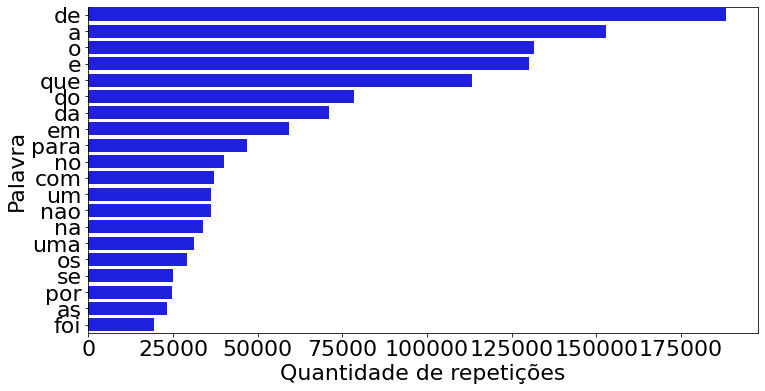

In [33]:
ax = sns.barplot(y='word', x='count', data=df_verdadeiro_count[:20],  color = 'blue')
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.show()

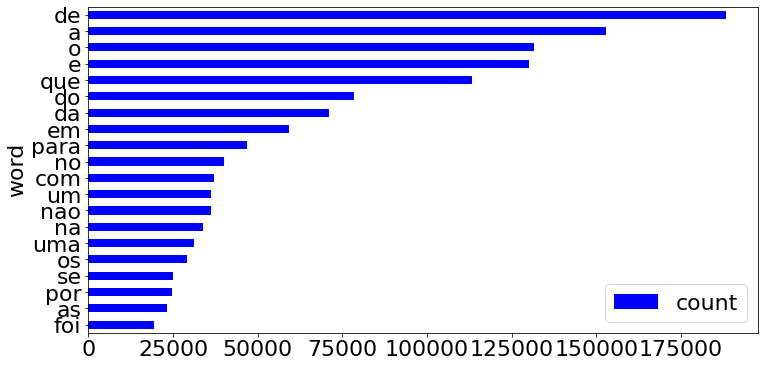

In [34]:
df_verdadeiro_count[:20].plot.barh(x='word', y='count', color='blue').invert_yaxis()
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 20})

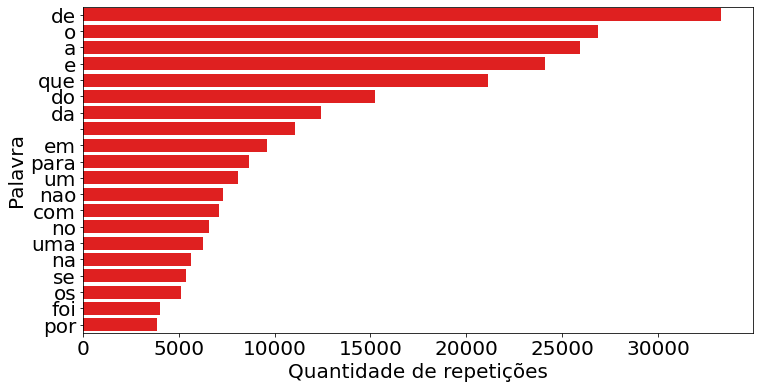

In [35]:
ax = sns.barplot(y='word', x='count', data=df_falso_count[:20], color='red')
plt.gcf().set_size_inches(12,6)
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.rcParams.update({'font.size': 22})

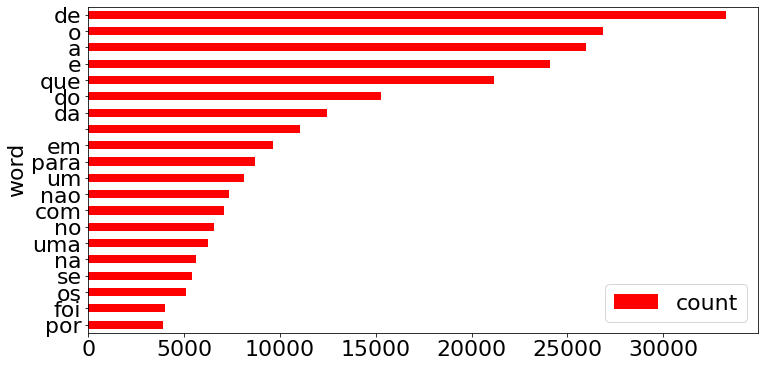

In [36]:
df_falso_count[:20].plot.barh(x='word', y='count', color='red').invert_yaxis()
plt.gcf().set_size_inches(12,6)


In [37]:
df_verdadeiro_mc_whithout_sw = pd.DataFrame(verdadeiro_count.most_common(), columns=['word', 'count'])
df_falso_mc_whithout_sw = pd.DataFrame(falso_count.most_common(), columns=['word', 'count'])

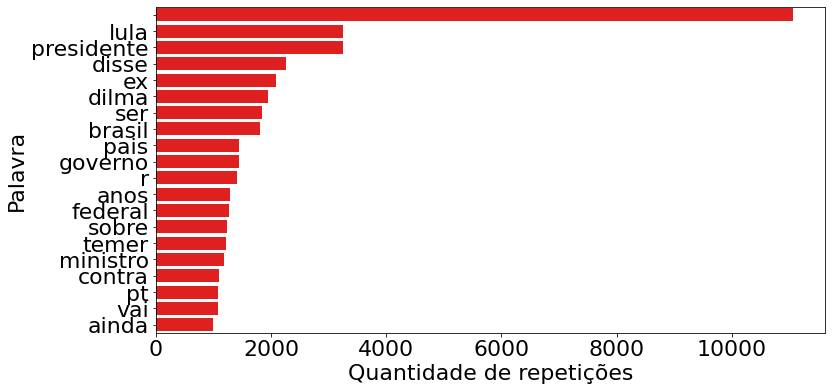

In [38]:
ax = sns.barplot(y='word', x='count', data=df_falso_mc_whithout_sw[:20], color='red')
plt.gcf().set_size_inches(12,6)
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.rcParams.update({'font.size': 22})

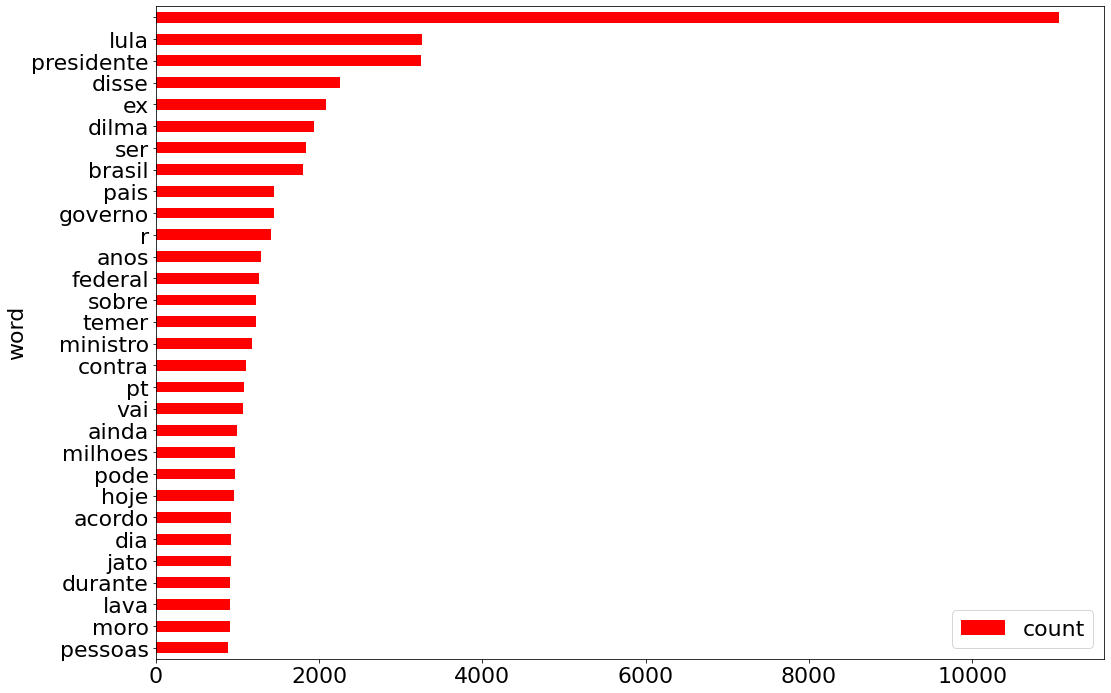

In [39]:
df_falso_mc_whithout_sw.sort_values(by='count', ascending=False)
df_falso_mc_whithout_sw[:30].plot.barh(x='word', y='count', color='red').invert_yaxis()
plt.gcf().set_size_inches(17,12)
plt.rcParams.update({'font.size': 22})

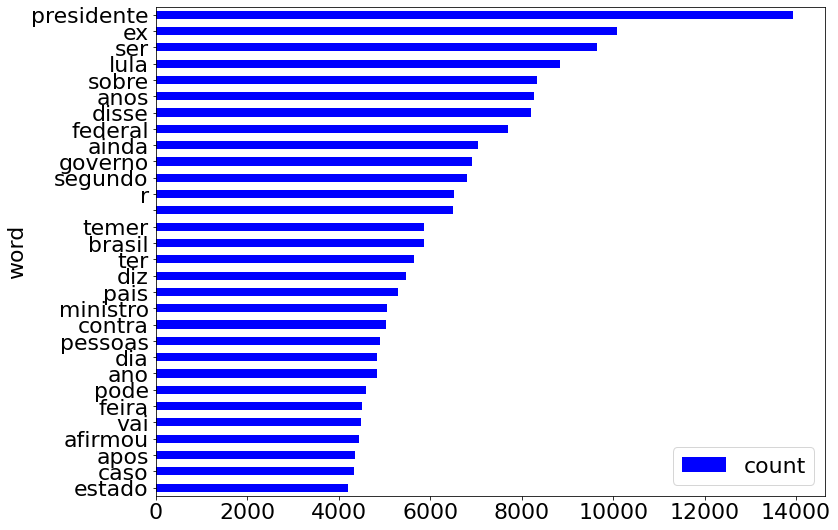

In [40]:
df_verdadeiro_mc_whithout_sw.sort_values(by='count', ascending=False)
df_verdadeiro_mc_whithout_sw[:30].plot.barh(x='word', y='count', color='blue').invert_yaxis()
plt.gcf().set_size_inches(12,9)
plt.rcParams.update({'font.size': 20})

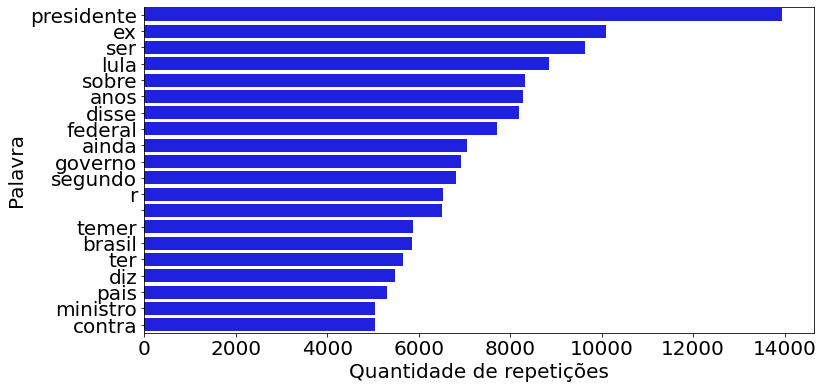

In [41]:
ax = sns.barplot(y='word', x='count', data=df_verdadeiro_mc_whithout_sw[:20], color='blue')
plt.gcf().set_size_inches(12,6)
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.rcParams.update({'font.size': 22})

In [42]:
from wordcloud import WordCloud, ImageColorGenerator

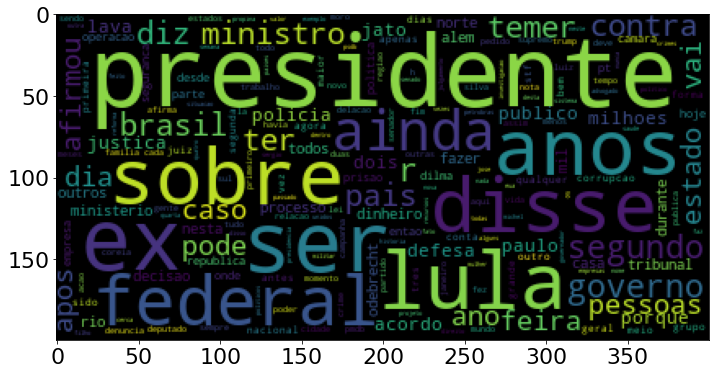

In [43]:
verdadeiro_cloud = WordCloud(stopwords=stopwords).generate_from_frequencies(verdadeiro_count)

plt.imshow(verdadeiro_cloud)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

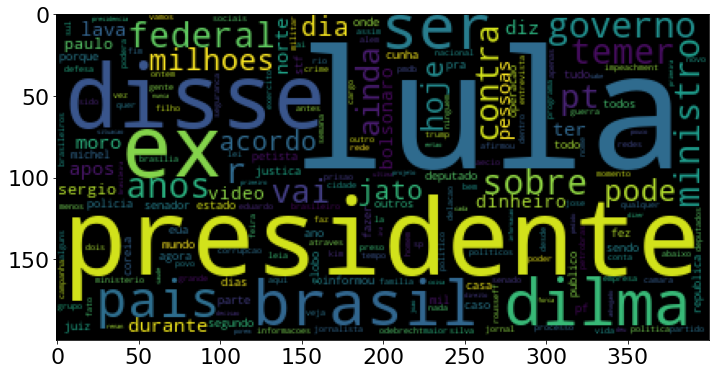

In [44]:
falso_count_cloud = WordCloud(stopwords=stopwords).generate_from_frequencies(falso_count)

plt.imshow(falso_count_cloud)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

In [45]:
#Quantidade total de noticias
total = len(todas_noticias)
total

12511

In [46]:
#total de falsas
total_falsas = len(todas_noticias[todas_noticias.classificacao == 'falso'])
total_falsas

7497

In [47]:
#total de verdadeiras
total_verdadeiras = len(todas_noticias[todas_noticias.classificacao == 'verdadeiro'])
total_verdadeiras

5014

In [48]:
#Porcentagem falsa
porcentagem_falsa = total_falsas / total * 100
porcentagem_verdadeira = total_verdadeiras / total * 100

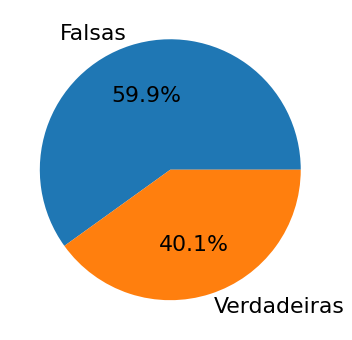

In [49]:
fatias = [porcentagem_falsa, porcentagem_verdadeira]
labels = ['Falsas', 'Verdadeiras']
fig1 = plt.subplot()
ax = fig1.pie(fatias, labels=labels, autopct='%1.1f%%')
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

plt.show()


In [50]:
## Media
falsas = todas_noticias[todas_noticias.classificacao == 'falso']
somatorio_falsas = falsas.texto.map(lambda x: len(x))
somatorio_falsas.mean()

584.8991596638656

In [51]:
## Media
verdadeiras = todas_noticias[todas_noticias.classificacao == 'verdadeiro']
somatorio_verdadeiras = verdadeiras.texto.map(lambda x: len(x))
somatorio_verdadeiras.mean()

4635.04128440367

In [52]:
#Mediana
somatorio_falsas.median()

300.0

In [53]:
#Mediana
somatorio_verdadeiras.median()

4026.0

In [54]:
#Moda
somatorio_falsas.mode()

0    79
dtype: int64

In [55]:
#Moda
somatorio_verdadeiras.mode()

0    69
dtype: int64

In [56]:
np.seterr(divide = 'ignore') 
razao_falso_verdadeira_log = {k: np.log(v) for k, v in razao_falso_verdadeira.items()}

In [57]:
s  = pd.Series(razao_falso_verdadeira_log,index=razao_falso_verdadeira_log.keys()).to_frame()
s.rename(columns = {0: 'razao'}, inplace=True)
s.head()

s.replace([np.inf, -np.inf], np.nan, inplace=True)
s.dropna(inplace=True)
s['razao'] = s['razao'].map(lambda x: np.float(x))


<ipython-input-57-418eeb3aee71>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  s['razao'] = s['razao'].map(lambda x: np.float(x))


In [58]:
hist_counter = collections.Counter(s.to_dict())

In [59]:
razao_range = np.arange(min(s['razao']), max(s['razao']), 0.2)

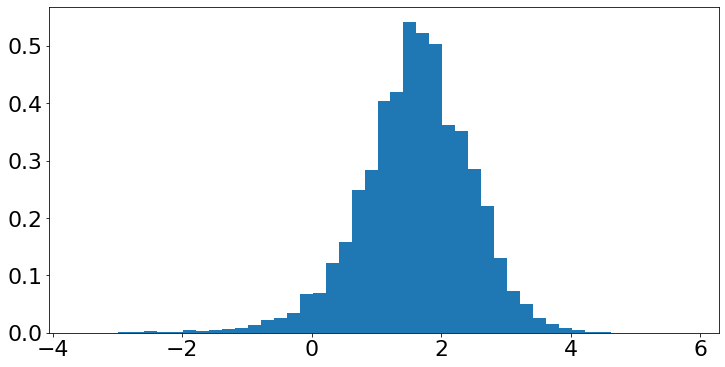

In [60]:
hist = plt.hist(s['razao'],density=True,bins=razao_range)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})
plt.show()


/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Razão'), Text(0, 0.5, 'Densidade')]

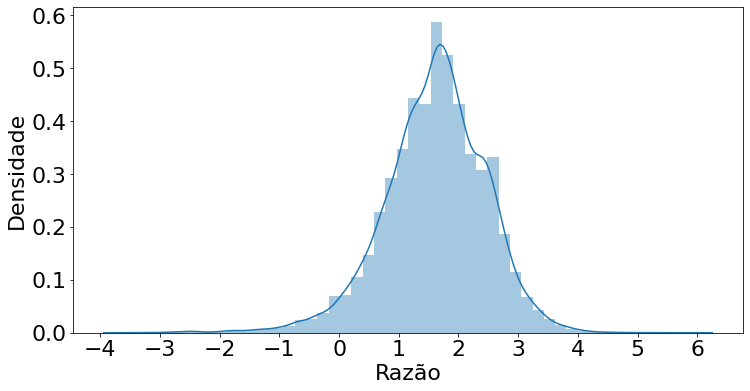

In [61]:
raz = sns.distplot(s['razao'])
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})
raz.figure.set_size_inches(12,6)
raz.set_xticks(range(-4,7))
raz.set(xlabel='Razão', ylabel='Densidade')

In [ ]:
verdadeiras = []
for nome, cont in verdadeiro_count.items():
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        if not np.isinf(ratio):
            verdadeiras.append({'palavra':nome, 'cont': cont, 'ratio': ratio})
verdadeiras = pd.DataFrame(verdadeiras)
verdadeiras.sample(5)
min(verdadeiras['ratio'])

In [ ]:
falsas = []
for nome, cont in falso_count.items():
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        if not np.isinf(ratio):
            falsas.append({'palavra':nome, 'cont': cont, 'ratio': ratio})
falsas = pd.DataFrame(falsas)

falsas.sample(5)


In [ ]:
data_ratio = pd.DataFrame.from_dict(razao_falso_verdadeira_log, orient='index').reset_index()

data_ratio.rename(columns={'index':'word', 0:'ratio'}, inplace=True)
data_ratio.head(10)

In [ ]:
stop = []
for nome in stopwords:
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        cont = todas_count[nome]
        if not np.isinf(ratio):
            stop.append({'palavra':nome, 'cont': cont, 'ratio': ratio})
stop = pd.DataFrame(stop)
stop.sample(5)

In [ ]:
stop_df = []
for nome in stopwords:
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        cont = todas_count[nome]
        if not np.isinf(ratio):
            stop_df.append({'palavra':nome, 'count': cont, 'ratio': ratio, 'classe':'Neutro'})
stop_df = pd.DataFrame(stop_df)
stop_df.sample(5)

In [ ]:
stop_df.rename(columns={'palavra':'word', 'cont':'count'}, inplace=True)

In [ ]:
falsas['classe'] = 'Flaso'

In [ ]:
falsas.rename(columns={'palavra': 'word', 'cont': 'count'}, inplace=True)

In [ ]:
verdadeiras['classe'] = 'Verdadeiro'

In [ ]:
verdadeiras.rename(columns={'palavra': 'word', 'cont': 'count'}, inplace=True)

In [ ]:
all_count_ratio = pd.concat([stop_df, verdadeiras, falsas])

In [ ]:
all_count_ratio.head()

In [ ]:
ax = sns.boxplot(x='classe', y='ratio', data=all_count_ratio)
ax.figure.set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

In [ ]:
ax = sns.violinplot(x='classe', y='ratio', data=all_count_ratio)
ax.figure.set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

In [ ]:
ax = sns.catplot(x='classe',y='ratio', data=all_count_ratio, height=10, s=3,  palette={'Neutro':'g','Verdadeiro':'b','Flaso':'r'})
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

In [ ]:
sns.relplot(x='count', y='ratio', hue='classe', col='classe', data=all_count_ratio)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 20})

In [ ]:
len(falsas)

In [ ]:
len(falsas)
ax = sns.lmplot(x='count', y='ratio', data=falsas)
ax.set(xlabel='Quantidade', ylabel='Razão')
plt.gcf().set_size_inches(12, 6)
plt.rcParams.update({'font.size': 22})


In [ ]:
ax = sns.lmplot(x='count', y='ratio', data=verdadeiras)
ax.set(xlabel='Quantidade', ylabel='Razão')
plt.gcf().set_size_inches(12, 6)
plt.rcParams.update({'font.size': 22})

In [ ]:
ax = sns.lmplot(x='cont', y='ratio', data=stop)
ax.set(xlabel='Quantidade', ylabel='Razão')
plt.gcf().set_size_inches(12, 6)

plt.rcParams.update({'font.size': 14})

In [ ]:
from scipy.stats import ranksums
pvalue = ranksums(falsas['ratio'], verdadeiras['ratio']).pvalue
pvalue

In [ ]:
from scipy.stats import ranksums
pvalue_count = ranksums(falsas['count'], verdadeiras['count'])
pvalue_count.pvalue

In [ ]:
plt.rc('figure', figsize=(10,5))
hist = plt.hist(verdadeiras['ratio'],density=True,bins=razao_range)
plt.show()

In [ ]:
hist = plt.hist(falsas['ratio'],density=True,bins=razao_range)
plt.show()

In [ ]:
ax = sns.displot(verdadeiras['ratio'])
plt.gcf().set_size_inches(12, 6)

In [ ]:
sns.displot(falsas['ratio'])
plt.gcf().set_size_inches(12, 6)

In [ ]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

ax1.hist(falsas['ratio'],density=True,bins=razao_range, color = 'red')
ax1.hist(verdadeiras['ratio'],density=True,bins=razao_range, color = 'blue')
#plt.rc('figure', figsize = (10,10))
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)


ax1.hist(verdadeiras['ratio'],density=True,bins=razao_range, color = "blue")
ax1.hist(falsas['ratio'],density=True,bins=razao_range, color = "red")
plt.show()

In [ ]:
verdadeiras

In [ ]:
verdadeiras.query('word == "racista"')

In [ ]:
falsas.query('word == "racista"')

In [ ]:
falso_count['cloroquina']

In [ ]:
verdadeiro_count['cloroquina']

In [ ]:
fig = plt.figure(figsize=(12,6))
falso_para_verdadeiro = []
for palavra in falso_count.keys():
    if palavra not in verdadeiro_count.keys():
        falso_para_verdadeiro.append({'palavra': palavra, 'cont': falso_count[palavra]})
falso_para_verdadeiro = pd.DataFrame(falso_para_verdadeiro)
falso_para_verdadeiro.sort_values(by='cont', ascending=False)[0:20]

falso_para_verdadeiro.sort_values(by='cont', ascending=False, inplace=True)
ax = falso_para_verdadeiro[:30].plot.barh(x='palavra', y='cont', color='red').invert_yaxis()
plt.gcf().set_size_inches(15, 10)

In [ ]:
ax = sns.barplot(y='palavra', x='cont', data=falso_para_verdadeiro[:30])
plt.gcf().set_size_inches(15, 10)

In [ ]:
verdadeiro_para_falso = []
for palavra in verdadeiro_count.keys():
    if palavra not in falso_count.keys():
        verdadeiro_para_falso.append({'palavra': palavra, 'cont': verdadeiro_count[palavra]})
verdadeiro_para_falso = pd.DataFrame(verdadeiro_para_falso)
verdadeiro_para_falso.sort_values(by='cont', ascending=False)[0:20]

verdadeiro_para_falso.sort_values(by='cont', ascending=False, inplace=True)
verdadeiro_para_falso[:30].plot.barh(x='palavra', y='cont', color='blue').invert_yaxis()
plt.gcf().set_size_inches(15, 10)

In [ ]:
ax = sns.barplot(y='palavra', x='cont', data=verdadeiro_para_falso[:30])
plt.gcf().set_size_inches(15, 10)

## Construindo um modelo

- Funções utilitárias

In [ ]:
def formatar_lote_de_noticias(noticias):
    lote = []
    for i, linha in noticias.iterrows():
        contagem = dict.fromkeys(vocabulario, 0)
        palavras = linha['texto'].split()
        
        for palavra in palavras:
            contagem[palavra] += 1
        lote.append(contagem)
    
    return pd.DataFrame(lote)

In [ ]:
def formatar_lote_de_noticias_sim_nao(noticias):
    lote = []
    for i, linha in noticias.iterrows():
        contagem = dict.fromkeys(vocabulario, 0)
        palavras = linha['texto'].split()
        
        for palavra in palavras:
            contagem[palavra] = 1
        lote.append(contagem)
    
    return pd.DataFrame(lote)

In [ ]:
def format_labels(y_train):
    rows = []
    for value in y_train:
        if value == 0:
            rows.append([0,1])
        else:
            rows.append([1,0])
    return rows

In [ ]:
def classificar_noticia(est, noticia):
    classe = est.predict(formatar_lote_de_noticias(pd.DataFrame([{'texto':noticia}])))[0]
    return 'Verdadeiro' if classe == 1 else 'Falso'

In [ ]:
def classify(result):
    if(result[0] == 0 and result[1] == 1):
        return 0
    else:
        return 1

- Construção dos modelos

In [ ]:
tamanho_lote = 128

In [ ]:
noticia = 'cloroquina salva milhoes em tratamento precoce'

In [ ]:
noticias, classes = todas_noticias['texto'].to_frame(),todas_noticias['classificacao'].to_frame()

In [ ]:
classes.classificacao = classes.classificacao.map(lambda x: 0 if x == 'falso' else 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(noticias, classes['classificacao'].array, random_state=42)

validacao_treino, validacao_classe = X_test[:2*tamanho_lote], y_test[:2*tamanho_lote]

X_test, y_test = X_test[2*tamanho_lote:], y_test[2*tamanho_lote:]

In [ ]:
len(X_test)

In [ ]:
x_test = formatar_lote_de_noticias(X_test)

In [ ]:
x_test_sn = formatar_lote_de_noticias_sim_nao(X_test)

In [ ]:
x_test_batch = formatar_lote_de_noticias(X_test[0:128]).to_numpy()
y_test_batch = np.asanyarray(format_labels(y_test[0:128].to_numpy()))

In [ ]:
val_formated = formatar_lote_de_noticias(validacao_treino).to_numpy()
val_formated_class = np.asanyarray(format_labels(validacao_classe.to_numpy()))

In [ ]:
val_formated_sn = formatar_lote_de_noticias_sim_nao(validacao_treino).to_numpy()
val_formated_class_sn = np.asanyarray(format_labels(validacao_classe.to_numpy()))

In [ ]:
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

target_names = ['Falso', 'Verdadeiro']

### Importando modelos utilizados

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier
from keras.models import load_model
import tensorflow as tf

In [ ]:
stats = []

## SGD Classifier

- Testando modelo SGD Classifier

In [ ]:


est = SGDClassifier(loss='log', penalty='l2', tol=1e-3)

## Treinando

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    est.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = est.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo SGD

In [ ]:
joblib.dump(est, 'sgd.sav')

### Carregar modelo SGD

In [ ]:
sgd_model = joblib.load('sgd.sav')

- Classificar usando modelo SGD

In [ ]:
classificar_noticia(sgd_model, noticia)

- Resultados do modelo

In [ ]:
sgd_model.score(x_test, y_test)

## Confusion Matrix

In [ ]:
sgd_pred = sgd_model.predict(x_test)

confusion_matrix(y_test, sgd_pred)

## Accuracy Score

In [ ]:
set(sgd_pred)
set(y_test)

In [ ]:
accuracy_score(y_test, sgd_pred)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_test,sgd_pred,average='macro')
print('Precision : {}'.format(precision))
print('Recall    : {}'.format(recall))
print('F-score   : {}'.format(fscore))
print('Support   : {}'.format(support))

## Classification Report

In [ ]:
report = classification_report(y_test, sgd_pred, target_names=target_names,  output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'sgd_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## SGD Classifier em dados de sim ou não

In [ ]:
est_sn = SGDClassifier(loss='log', penalty='l2', tol=1e-3)

## Treinando

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    est_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = est_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo SGD (contains)

In [ ]:
joblib.dump(est_sn, 'sgdsn.sav')

### Carregar modelo SGD (contains)

In [ ]:
sgdsn_model_sn = joblib.load('sgdsn.sav')

- Classificar usando modelo SGD (contains)

In [ ]:
classificar_noticia(sgdsn_model_sn, noticia)

- Resultados do modelo





In [ ]:
sgdsn_model_sn.score(x_test_sn, y_test)

## Confusion Matrix

In [ ]:
sgdsn_pred = sgdsn_model_sn.predict(x_test_sn)

confusion_matrix(y_test, sgdsn_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, sgdsn_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, sgdsn_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'sgd_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## MultinomialNB

In [ ]:
clf = MultinomialNB()
## Treinando
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    clf.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = clf.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo MultinomialNB

In [ ]:
joblib.dump(est_sn, 'MultinomialNB.sav')

### Carregar modelo MultinomialNB

In [ ]:
multinb_model = joblib.load('MultinomialNB.sav')

- Classificar usando modelo MultinomialNB

In [ ]:
classificar_noticia(multinb_model, noticia)

- Resultados do modelo

In [ ]:
multinb_model.score(x_test, y_test)

## Confusion Matrix

In [ ]:
multinb_model_pred = multinb_model.predict(x_test)

confusion_matrix(y_test, multinb_model_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, multinb_model_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, multinb_model_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'multinomial_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## MultiomailNB Classifier em dados de sim ou não

In [ ]:
clf_sn = MultinomialNB()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    clf_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = clf_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo MultinomialNB

In [ ]:
joblib.dump(est_sn, 'MultinomialNBSN.sav')

### Carregar modelo MultinomialNB

In [ ]:
multinb_model_sn = joblib.load('MultinomialNB.sav')

- Classificar usando modelo MultinomialNB

In [ ]:
classificar_noticia(multinb_model_sn, noticia)

- Resultados do modelo

In [ ]:
multinb_model_sn.score(x_test, y_test)

## Confusion Matrix

In [ ]:
multinb_model_pred_sn = multinb_model_sn.predict(x_test_sn)
confusion_matrix(y_test, multinb_model_pred_sn)

## Accuracy Score

In [ ]:
accuracy_score(y_test, multinb_model_pred_sn)

## Classification Report

In [ ]:
report = classification_report(y_test, multinb_model_pred_sn, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'multinomial_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

# Perceptron

In [ ]:
percep = Perceptron()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    percep.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = percep.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Perceptron

In [ ]:
joblib.dump(percep, 'Percep.sav')

### Carregar modelo Perceptron


In [ ]:
perceb_model = joblib.load('Percep.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(perceb_model, noticia)

- Resultados do modelo

In [ ]:
perceb_model.score(x_test, y_test)


## Confusion Matrix

In [ ]:
perceb_model_pred = perceb_model.predict(x_test)
confusion_matrix(y_test, perceb_model_pred)

## Accuracy Score

In [ ]:

accuracy_score(y_test, perceb_model_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, perceb_model_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'percep_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Perceptron sim ou não

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    percep_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = percep_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Perceptron

In [ ]:
joblib.dump(percep_sn, 'percep_sn.sav')

### Carregar modelo Perceptron

In [ ]:
perceb_model_sn = joblib.load('percep_sn.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(perceb_model_sn, noticia)

- Resultados do modelo

In [ ]:
perceb_model_sn.score(x_test_sn, y_test)

## Confusion Matrix

In [ ]:
perceb_model_pred_sn = perceb_model_sn.predict(x_test_sn)
confusion_matrix(y_test, perceb_model_pred_sn)

## Accuracy Score


In [ ]:
accuracy_score(y_test, perceb_model_pred_sn)

## Classification Report

In [ ]:
report = classification_report(y_test, perceb_model_pred_sn, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'percep_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Bernouli

In [ ]:
bern_count = BernoulliNB()
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    bern_count.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = bern_count.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Perceptron

In [ ]:
joblib.dump(percep_sn, 'bernouli.sav')

### Carregar modelo Perceptron

In [ ]:
bern_model = joblib.load('bernouli.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(bern_model, noticia)

- Resultados do modelo

In [ ]:
bern_model.score(x_test, y_test)

## Confusion Matrix

In [ ]:
bern_model_pred = bern_model.predict(x_test)
confusion_matrix(y_test, bern_model_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, bern_model_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, bern_model_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'bernouli_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

In [ ]:
stats

## Bernouli Sim ou Não

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    bern.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = bern.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Bernouli

In [ ]:
joblib.dump(bern, 'bernoulisn.sav')

### Carregar modelo Perceptron

In [ ]:
bern_model_sn = joblib.load('bernoulisn.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(bern_model_sn, noticia)

- Resultados do modelo

In [ ]:
bern_model_sn.score(x_test_sn, y_test)

## Confusion Matrix

In [ ]:
bern_model_sn_pred = bern_model_sn.predict(x_test_sn)
confusion_matrix(y_test, bern_model_sn_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, bern_model_sn_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, bern_model_sn_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'benouli_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Passive agressive classifier

In [ ]:
passive = PassiveAggressiveClassifier()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    passive.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = passive.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Passive Agressive

In [ ]:
joblib.dump(passive, 'passive.sav')

### Carregar modelo Passive Agressive

In [ ]:
passive_model = joblib.load('passive.sav')

- Classificar usando modelo Passive Agressive

In [ ]:
classificar_noticia(passive_model, noticia)

- Resultados do modelo

In [ ]:
passive_model.score(x_test, y_test)

## Confusion Matrix

In [ ]:
passive_model_pred = passive_model.predict(x_test)
confusion_matrix(y_test, passive_model_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, passive_model_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, passive_model_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'passive_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)


## Passive agressive classifier Sim Não

In [ ]:
passive_sn = PassiveAggressiveClassifier()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    passive_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = passive_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Passive Agressive

In [ ]:
joblib.dump(passive_sn, 'passivesn.sav')

### Carregar modelo Perceptron

In [ ]:
passive_model_sn = joblib.load('passivesn.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(passive_model_sn, noticia)

- Resultados do modelo

In [ ]:
passive_model_sn.score(x_test_sn, y_test)

## Confusion Matrix

In [ ]:
passive_model_sn_pred = passive_model_sn.predict(x_test_sn)
confusion_matrix(y_test, passive_model_sn_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, passive_model_sn_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, passive_model_sn_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'passive_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Redes Neurais

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [ ]:


inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model.fit(x_train.to_numpy(), y_tr, epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Rede Neural

In [ ]:
model.save('keras_finished_count_2.h5')

### Carregar modelo Rede Neural

In [ ]:
keras_model = load_model('keras_finished_count_2.h5')

- Resultados do modelo


In [ ]:
score, acc = keras_model.evaluate(x_test_batch, y_test_batch)
print(f"Score: {score}")
print(f"Accuracy: {acc}")

## Confusion Matrix

In [ ]:
y_pred_keras = keras_model.predict(x_test.to_numpy()).round()
y_pred_keras = [classify(result) for result in y_pred_keras]
confusion_matrix(y_test, y_pred_keras)

## Accuracy Score

In [ ]:
accuracy_score(y_test, y_pred_keras)

## Classification Report

In [ ]:
report = classification_report(y_test, y_pred_keras, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'keras_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Keras Contains

In [ ]:
model_contains = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model_contains.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model_contains.fit(x_train.to_numpy(), y_tr, epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

### Exportando o modelo Rede Neural

In [ ]:
model_contains.save('keras_finished_contains_2.h5')

### Carregar modelo Rede Neural

In [ ]:
keras_model_sn = load_model('keras_finished_contains_2.h5')

- Resultados do modelo

In [ ]:
score, acc = keras_model_sn.evaluate(x_test_batch, y_test_batch)
print(f"loss: {score}")
print(f"Accuracy: {acc}")

## Confusion Matrix

In [ ]:
y_pred_keras_sn = keras_model_sn.predict(x_test_sn.to_numpy()).round()
y_pred_keras_sn = [classify(result) for result in y_pred_keras_sn]
confusion_matrix(y_test, y_pred_keras_sn)

## Accuracy Score

In [ ]:
accuracy_score(y_test, y_pred_keras_sn)

## Classification Report

In [ ]:
report = classification_report(y_test, y_pred_keras_sn, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'keras_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Keras Contains Validation

In [ ]:
model_ = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model_.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model_.fit(x=x_train.to_numpy(), y=y_tr, validation_data=(val_formated, val_formated_class), epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

### Exportando o modelo Rede Neural

In [ ]:
model_.save('keras_finished_count_val_2.h5')

### Carregar modelo Rede Neural

In [ ]:
keras_model_val = load_model('keras_finished_count_val_2.h5')

- Resultados do modelo

In [ ]:
score, acc = keras_model_val.evaluate(x_test_batch, y_test_batch)
print(f"Score: {score}")
print(f"Accuracy: {acc}")

## Confusion Matrix

In [ ]:
y_pred_keras_val = keras_model_val.predict(x_test.to_numpy()).round()
y_pred_keras_val = [classify(result) for result in y_pred_keras_val]
confusion_matrix(y_test, y_pred_keras_val)

## Accuracy Score

In [ ]:
accuracy_score(y_test, y_pred_keras_val)

## Classification Report

In [ ]:
report = classification_report(y_test, y_pred_keras_val, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'keras_count_val', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Keras Contains Validation Sim/Não

In [ ]:
model_sn = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model_sn.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model_sn.fit(x=x_train.to_numpy(), y=y_tr, validation_data=(val_formated_sn, val_formated_class_sn), epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

### Exportando o modelo Rede Neural

In [ ]:
model_sn.save('keras_model_sn_val_2.h5')

### Carregar modelo Rede Neural

In [ ]:
keras_model_val_sn = load_model('keras_model_sn_val.h5')

- Resultados do modelo

In [ ]:
score, acc = keras_model_val_sn.evaluate(x_test_batch, y_test_batch)
print(f"loss: {score}")
print(f"Accuracy: {acc}")

## Confusion Matrix

In [ ]:
y_pred_keras_sn_val = model_sn.predict(x_test_sn.to_numpy()).round()
y_pred_keras_sn_val = [classify(result) for result in y_pred_keras_sn_val]
confusion_matrix(y_test, y_pred_keras_sn_val)

## Accuracy Score

In [ ]:
accuracy_score(y_test, y_pred_keras_sn_val)

## Classification Report

In [ ]:
report = classification_report(y_test, y_pred_keras_sn_val, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'keras_contains_val', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

In [ ]:
stats_df = pd.DataFrame(stats)

In [ ]:
stats_df

In [ ]:
stats_df.to_csv('model_stats.csv')

In [ ]:
stats_df.accuracy = stats_df.accuracy.map(lambda i:i*100)

In [ ]:
stats_df.recall = stats_df.recall.map(lambda i:i*100)
stats_df.f1_score = stats_df.f1_score.map(lambda i:i*100)
stats_df.support = stats_df.support.map(lambda i:i*100)
stats_df.falso_precision = stats_df.falso_precision.map(lambda i:i*100)
stats_df.falso_recall = stats_df.falso_recall.map(lambda i:i*100)
stats_df.falso_f1_score = stats_df.falso_f1_score.map(lambda i:i*100)
stats_df.verdadeiro_precision = stats_df.verdadeiro_precision.map(lambda i:i*100)
stats_df.verdadeiro_recall = stats_df.verdadeiro_recall.map(lambda i:i*100)
stats_df.verdadeiro_f1_score = stats_df.verdadeiro_f1_score.map(lambda i:i*100)

In [ ]:
stats_df.to_csv('model_stats_formatted.csv')

In [6]:
stats_df = pd.read_csv('estatisticas/model_stats_formatted.csv')

In [7]:
stats_df.head()

,Unnamed: 0,model,accuracy,recall,f1_score,support,falso_precision,falso_recall,falso_f1_score,verdadeiro_precision,verdadeiro_recall,verdadeiro_f1_score
0,0,sgd_count,60.863510,50.000000,37.835498,287200,60.863510,100.000000,75.670996,0.000000,0.000000,0.000000
1,1,sgd_contains,41.747911,50.207965,36.781197,287200,61.755486,11.270023,19.061442,39.247944,89.145907,54.500952
2,2,multinomial_count,60.898329,50.044484,37.932578,287200,60.884709,100.000000,75.687378,100.000000,0.088968,0.177778
3,3,multinomial_contains,60.898329,50.044484,37.932578,287200,60.884709,100.000000,75.687378,100.000000,0.088968,0.177778
4,4,percep_count,60.341226,49.761497,38.600031,287200,60.748323,98.455378,75.136433,30.769231,1.067616,2.063629


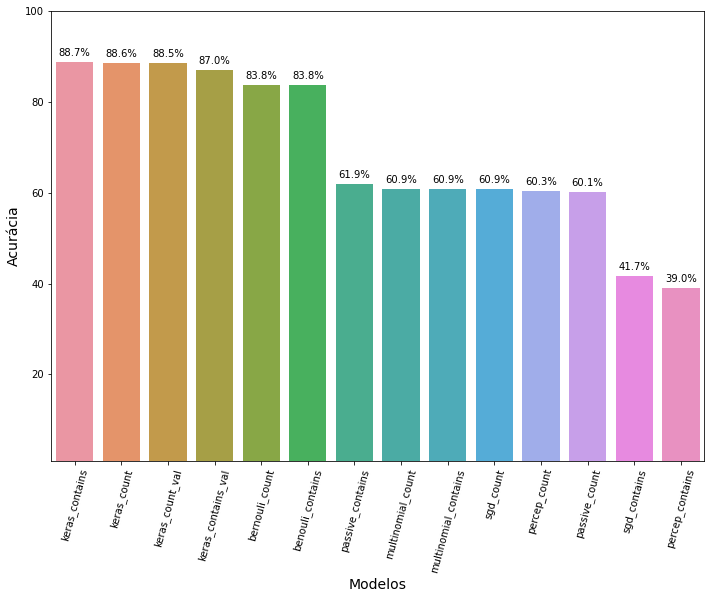

In [8]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'accuracy', data=stats_df.sort_values(['accuracy'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Acurácia", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,100)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'recall', data=stats_df.sort_values(['recall'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Recall", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,100)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'f1_score', data=stats_df.sort_values(['f1_score'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("F1 Score", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,100)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'verdadeiro_precision', data=stats_df.sort_values(['verdadeiro_precision'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Precisão Verdadeiro", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'falso_precision', data=stats_df.sort_values(['falso_precision'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Precisão Falso", size=14)
plt.savefig("Precisão Falso.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
		verdadeiro_recall	

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'falso_f1_score', data=stats_df.sort_values(['falso_f1_score'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Falso F1 Score", size=14)
plt.savefig("Precisão Falso.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'verdadeiro_precision', data=stats_df.sort_values(['verdadeiro_precision'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Verdadeiro F1 Score", size=14)
plt.savefig("Precisão Falso.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'verdadeiro_recall', data=stats_df.sort_values(['verdadeiro_recall'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Verdadeiro Recall", size=14)
plt.savefig("Verdadeiro Recall.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'falso_recall', data=stats_df.sort_values(['falso_recall'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Falso Recall", size=14)
plt.savefig("Falso Recall.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()